All of the necessary imports

In [7]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import glob

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file

%matplotlib inline

Retrieving the DEM files and importing into progam as a rasterModelGrid

[334009]


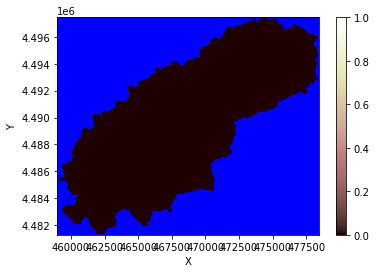

In [8]:
#Set directory paths to retrieve the asc file
path_project = r"C:/Users/gsbir/Documents/EES_393/" # add the path to the asc file    #this should access my H drive
filename_dem = "saucon_30m.txt" #the name of the ascii file
path_dem = path_project + filename_dem #gets the entire path to the ascii file

#now read the header of the asc file (where there is ncols nrows cell size and nodata value) into the string variable dem_header
dem_header = read_asc_header(open(path_dem, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(path_dem, name= 'topographic__elevation', halo = 1)

#set the watershed boundary condition and the function returns a integer which is the outlet_id so this is set equal to a variable so we can view this
outlet_id = mg.set_watershed_boundary_condition(z, nodata_value = -9999, return_outlet_id=True)

#This should find your outlet node automatically and outlet_id will be empty if a single outlet was not found

print(outlet_id) #prints out the outlet_id

#print(mg.at_node.keys()) #Shows the node attributes

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue') #creates a graph showing the red and the closed boundaries are set to blue, black is the landscape and white is the outlet ID (cannot see it at this level)



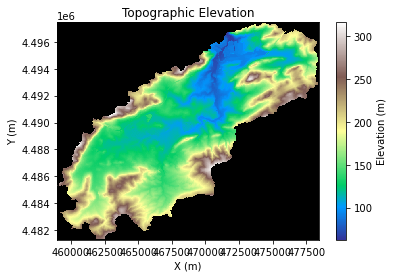

In [9]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

Adding new nodes to the rasterModelGrid: soil__depth, bedrock__elevation 

#Set grid parameters 
#these numbers are taken from the ascii header file
num_columns = 647
num_rows = 537
node_next_to_outlet = num_columns + 1
node_spacing = 30

#Set model timestep
timestep = 1 #years

#Set model run time
run_time = 2 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep


#Add field 'soil__depth' to the grid with 0s for now
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid with 0s for now
mg.add_zeros('bedrock__elevation', at='node')

#Subtract 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation'
mg.at_node['bedrock__elevation'][:] = mg.at_node['topographic__elevation'] - mg.at_node['soil__depth']



Setting Boundary Conditions of the Grid

In [3]:
#Set grid parameters
num_rows = 20
num_columns = 20
node_next_to_outlet = num_columns + 1
node_spacing = 100.0

#Set model timestep
timestep = 1.0 #years

#Set model run time
run_time = 100 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')

#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)

## Create initial model topography
#plane tilted towards the lower−left corner
topo = mg.node_y/100000 + mg.node_x/100000

#topographic roughness
random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid
mg['node']['topographic__elevation'] += (topo + random_noise) 

#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation'
#to yield 'topographic elevation'
mg.at_node['bedrock__elevation'][:] = mg.at_node['topographic__elevation'] 
mg.at_node['topographic__elevation'][:] += mg.at_node['soil__depth']


In [4]:
#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)

Instantiating all of the components

In [5]:
#Instantiate flow Router as fr
#fr = PriorityFloodFlowRouter(mg,surface='topographic__elevation', flow_metric='D8', runoff_rate=None, update_flow_depressions=True, depression_handler='fill', exponent=1, epsilon=False, accumulate_flow=True, accumulate_flow_hill=False, separate_hill_flow=False, update_hill_depressions=False, update_hill_flow_instantaneous=False, hill_flow_metric='D8', hill_exponent=1, suppress_out=False)
#fr.run_one_step() #run the flow router once 

K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8')  
fa.run_one_step() #run one step of flow doesnt get stuck in pits

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp=.001,m_sp=.5, n_sp=1)  
#fsc.run_one_step(1)

#Instantiate SPACE model with chosen parameters as sp
sp = Space(mg, K_sed=0.01, K_br=0.001, F_f=0., phi=0., H_star=1., v_s=5.0, m_sp=0.5, n_sp=1.0, sp_crit_sed=0, sp_crit_br=0)

theta = m_sp / n_sp
sf = SteepnessFinder(mg, reference_concavity = theta, min_drainage_area = 1000000.0)

cf = ChiFinder(mg,min_drainage_area=1000000.0,reference_concavity=theta, use_true_dx=True)

['topographic__elevation', 'soil__depth', 'bedrock__elevation', 'water__unit_flux_in', 'drainage_area', 'flow__data_structure_delta', 'flow__upstream_node_order', 'surface_water__discharge', 'flow__sink_flag', 'flow__link_to_receiver_node', 'flow__receiver_node', 'topographic__steepest_slope', 'depression__depth', 'depression__outlet_node', 'is_pit', 'flood_status_code', 'sediment__influx', 'sediment__outflux', 'sediment__flux', 'channel__steepness_index', 'channel__chi_index']
3240000.0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 

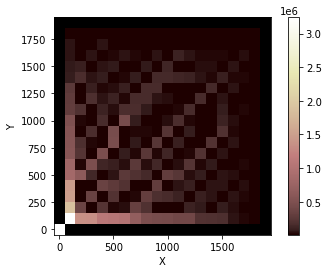

In [6]:
print(mg.at_node.keys()) #prints out all of the information that the nodes contain
imshow_grid(mg, 'drainage_area') #makes a graph of the node information 'drainage_area
print(np.max(mg.at_node['drainage_area']))

x = mg.node_x[mg.at_node['sediment__flux'] == np.max(mg.at_node['sediment__flux'])]
y =mg.node_y[mg.at_node['sediment__flux'] == np.max(mg.at_node['sediment__flux'])]
print(mg.find_nearest_node([x,y]))

Run the Model 

In [ ]:
#Set elapsed time to zero
elapsed_time = 0

#Set timestep count to zero
count = 0

#Array to save sediment flux values and is currently filled with 0s
sed_flux = [0] * (run_time)                                

#This will iterate through all of the years needed and will essentially run the model
while elapsed_time < run_time: #time units of years
    mg.at_node['bedrock__elevation'] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift
    
    #Run the flow router for one step (one step for each year)
    #for x in range(timestep): #loops through each year (how large the timestep is) and run the flow router
    fa.run_one_step()

    
    df.map_depressions()
    #Get list of nodes in depressions; only used if using DepressionFinderAndRouter
    #flooded = np.where(df.flood_status==3)[0] #flooded is a list of nodes of the depressions in the landscape -- orig status number was 3
    
    sp.run_one_step(dt = timestep) #runs the space model (sp) for one timestep - it iterates itself to run for each year in the timestep
    
    #Save sediment flux value to array
    sed_flux[count] = mg.at_node['sediment__flux'][21] ##creates the array sed_flux  and adds the sediment_flux value from the node into it
    
    elapsed_time += timestep #Add timestep value to elapsed time
    
    print(count) #prints out a number that is increaseing for each year - this is to keep track of the model as it is running for a large amount of time
    count += 1 #Increase timestep count


    

In [ ]:
print(np.max(sed_flux))



prf = ChannelProfiler(mg,
                      number_of_watersheds=1,
                      main_channel_only=True,
                      minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

In [ ]:
plt.figure(1)
title_text = f"$K_{{sp}}$={.001}; $time$={elapsed_time} yr; $dx$={timestep} m"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)',
                  title=title_text)

In [ ]:
#binning the drainage area and averaging out the slopes for that bin


K_sp = 1.0e-5

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg.at_node["drainage_area"][profile_ids],
            mg.at_node["topographic__steepest_slope"][profile_ids],
            '.',
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={node_spacing} m"
plt.title(title_text)

In [ ]:
# Code Block 12

# calculate channel steepness
sf.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(6)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(
            distance_upstream,
            mg.at_node["channel__steepness_index"][profile_ids],
            'x',
            color=color,
            label=label,
        )

plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
plt.title(
    f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m; concavity={theta}"
)

# channel steepness map
plt.figure(7)
imshow_grid(
    mg,
    "channel__steepness_index",
    grid_units=("m", "m"),
    var_name="Steepness index ",
    cmap="jet", limits =(0,500)
)
title_text = ("$K_{sp}$=" + str(K_sp) + "; $time$=" + str(elapsed_time) +
              "yr; $dx$=" + str(timestep) + "m" + "; concavity=" + str(theta))
plt.title(
    f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m; concavity={theta}"
)

In [ ]:
# Code Block 11

# calculate the chi index
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(4)
plt.ylim(0,175)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg.at_node["channel__chi_index"][profile_ids],
            mg.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m; concavity={theta}"
plt.title(title_text)

# chi map
plt.figure(5)
imshow_grid(
    mg,
    "channel__chi_index",
    grid_units=("m", "m"),
    var_name="Chi index (m)",
    cmap="jet",
)
title_text = f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m; concavity={theta}"
plt.title(title_text)

In [ ]:
for x in range(0, len(mg.at_node["sediment__flux"])):
    print(mg.at_node["sediment__flux"][x])


Create the Sediment Flux Figure

In [ ]:
#Instantiate an empty plot
figsed = plt.figure()

#Instantiate subplot empty
plot = plt.subplot()

#Create sed_flux graph that shows the landscape with the nodes where ther is sediment flux in different colors- using landlab utility imshow_grid
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='terrain')

Create the Topographic Elevation Figure

In [ ]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)

Create the Soil Depth Figure

In [ ]:
#Instantiate figure as empty plot
fig = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a graph showing the soil depth at each node in the landscape - using landlab utility imshow_grid
imshow_grid(mg, 'soil__depth', plot_name='Soil Depth', var_name = 'Depth', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

Create the Bedrock Elevation Figure

In [ ]:
#Instantiate figure as empty plot
fig = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a graph showing the bedrock elevation of the landscape - using landlab utility imshow_grid
imshow_grid(mg, 'bedrock__elevation', plot_name='Bedrock Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain')

Create the Sedimentograph

In [ ]:
#Instantiate figure as an empty plot
fig = plt.figure()

#Instantiate subplot as an empty plot
sedfluxplot = plt.subplot()

#Creates the information in the graph with the runtim values from 0 to the end of the run_time , and the sed_flux array creates while the model was running
sedfluxplot.plot(np.arange(run_time),sed_flux, color = 'k', linewidth = 3)

#Add axis labels to the plot 
sedfluxplot.set_title('Sedimentograph') #title
sedfluxplot.set_xlabel('Time [yr]') #x axis label
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]') #y axis label